# Usecase: Reflectance Map over Amsterdam

In this use case, you will create a mean reflectance map over Amsterdam using satellite aperture radar (SAR) dataset that is provided to you. You will create the mean reflectance map for Amsterdam by reading in binary data for 10 pre-processed satellite images. The reading and computation will be done using dask chunks whose size will be determined by you. The main aim of this use case is to provide an understanding of the dask chunking mechanism. You will perform multiple runs of this analysis chain with different chunking sizes to understand the effect of chunk size on performance of the code for reading and for analysis.

### Data used for this notebook
- Interferogram stack: Obtained from the caroline project and made available to you at `/project/stursdat/Data/sar_binary_data/`


### Setup environment
The packages for this use-case are self-contained in the jupyter_dask environment provided to you with this workshop. The following extra packages have been locally installed in the project directory at `/project/stursdat/Software/`

stm - space-time matrix from git@github.com:MotionbyLearning/stm.git
sarxarray to load the interferogram stack from git@github.com:MotionbyLearning/sarxarray.git


--- Initiate a Dask cluster here ---

--- you can use the Dask icon on the left of the Jupyter environment ---

--- In this demo we init a cluster with 4 workers --- *

\* - Please confirm the number of workers from your instructors before scaling up your dask cluster. 

### Load a SLC stack using SarXarray

In [2]:
# Import required libraries - preinstalled in your conda environment
import numpy as np
from pathlib import Path
import sarxarray

In [ ]:
# DO NOT MODIFY
# Path to data. Need to be absolute. You may need to change this manually
path = Path('/project/stursdat/Data/sar_binary_data/')

# Metadata of the stack, assume known
shape=(2000, 4000)

In [3]:
# Make a list of SLC paths to read
# Explore the files stored in the directory and create a list of the files (format: *_cint_srd.raw) to read
f_slc = 'cint_srd.raw'
list_slcs = [p for p in path.rglob('*_cint_srd.raw')]
list_slcs.sort()

# Create two variables with paths to the latitude and longitude files
# Geo referenced coordinates
f_lat = [path / 'lat.raw']
f_lon = [path / 'lon.raw']

In [5]:
# Define 2D Chunks for reading in parallel with dask
reading_chunks = (_,_)

# Load the SLC dataset - you can do this using the sarxarray function from_binary
# The function can be called as:
# from_binary(list_of_slc_paths, shape_of_slcs, dtype, dask_chunk_size)
# dtype for this dataset is np.complex64 
stack = sarxarray.from_binary(list_slcs, shape, dtype=np.complex64, chunks=reading_chunks)

# Load coordinates - this can also be done using the same from_binary function of sarxarray
lat = sarxarray.from_binary(f_lat, shape, vlabel="lat", dtype=np.float32, chunks=reading_chunks)
lon = sarxarray.from_binary(f_lon, shape, vlabel="lon", dtype=np.float32, chunks=reading_chunks)

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 4000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>

In [ ]:
# DO NOT MODIFY
stack = stack.assign_coords(lat = (("azimuth", "range"), lat.squeeze().lat.data), lon = (("azimuth", "range"), lon.squeeze().lon.data))
if stack.shape != [2000, 4000, 10]:
    print ('Data not read properly, please check your function')
else:
    print ('Data read successfully')
    stack

### Calculate the mean reflectance map

In [6]:
# You can calculate the mrm using the following command available from the sarxarray library
# stack.slcstack.mrm() 
# Use .compute to persist and calculate the values of the mrm.
mrm = stack.slcstack.mrm()
mrm = mrm.compute()

<xarray.DataArray 'amplitude' (azimuth: 2000, range: 4000)>
dask.array<mean_agg-aggregate, shape=(2000, 4000), dtype=float32, chunksize=(500, 500), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 ... 3993 3994 3995 3996 3997 3998 3999
    lat      (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon      (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>

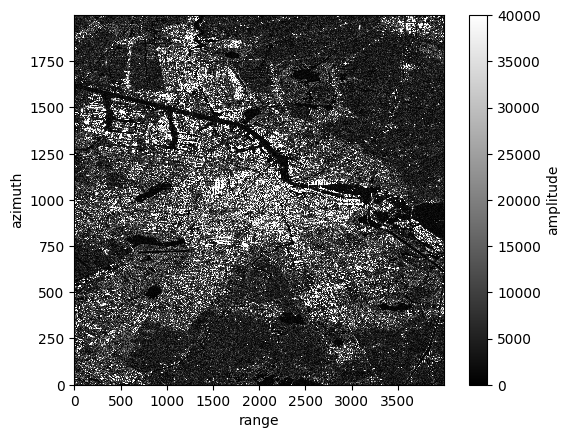

In [8]:
# Plot the mean reflectance map
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(mrm)
ax.set_aspect(2)
im = mrm.plot(ax=ax, cmap='gray')
im.set_clim([0, 40000])

### Challenge:

Rerun the above workflow for different chunk sizes and analyse the performance of the dask cluster. See if you can identify an optimal chunk size for this problem for the fixed worker size.

Hint: Use %%timeit at the top of a jupyter cell to time the execution time for the cell